In [1]:
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(threshold=10000)
import pandas as pd
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import train_test_split

from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
import seaborn as sns

In [2]:
fires = pd.read_csv('fire_features_with_derived.csv')

#split date into year/month/day feature
date = fires['Current Day'].values
years = [int(date[i][0:4]) for i in range(len(date))]
months = [int(date[i][5:7]) for i in range(len(date))]
days = [int(date[i][8:10]) for i in range(len(date))]
fires['years'] = years
fires['months'] = months
fires['days'] = days

#get rid of rows which contain nans/zeros for features
inds_features = np.where(fires['biomass_12Z']==0)


fires = fires.drop(labels=inds_features[0], axis=0)
fires

,Incident Number,Fire Name,Current Day,Lat Fire,Lon Fire,Number of VIIRS points,TLML_12Z,QLML_12Z,SPEEDLML_12Z,PS_12Z,...,biomass_12Z,ESATLML_12Z,ELML_12Z,HDWLML,Td_12Z_700mb,E_700mb,HAINES,years,months,days
0,10662684.0,PAINTED WAGON,2019-04-08,33.786944,-112.753333,3.0,290.748108,0.004608,10.770707,91644.742188,...,7.627477e-10,20.131931,2.638775,188.413662,-66.278872,0.008245,5.0,2019,4,8
13,10663171.0,LONE MOUNTAIN,2019-06-21,33.808056,-105.738611,9.0,291.568451,0.003356,7.488189,80981.914062,...,9.687870e-10,21.198124,1.695978,146.035756,-64.593229,0.010364,5.0,2019,6,21
23,10663171.0,LONE MOUNTAIN,2019-07-01,33.808056,-105.738611,0.0,291.934814,0.010633,4.458162,81414.648438,...,6.619176e-10,21.690044,5.442483,72.434264,-57.266238,0.026697,6.0,2019,7,1
24,10663171.0,LONE MOUNTAIN,2019-07-02,33.808056,-105.738611,9.0,290.191132,0.010948,4.315524,81379.093750,...,3.611985e-10,19.435098,5.602998,59.692758,-54.788338,0.036158,5.0,2019,7,2
28,10664535.0,Roaring,2019-06-07,33.893500,-108.996000,27.0,287.163910,0.004974,3.406101,77239.523438,...,3.626358e-09,16.005112,2.401526,46.335181,-58.488769,0.022917,5.0,2019,6,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8077,11976592.0,AIRPORT,2020-12-03,33.895278,-117.598056,52.0,281.269012,0.001763,11.389023,94925.812500,...,2.524405e-08,10.817664,1.042559,111.328892,-80.702418,0.000959,5.0,2020,12,3
8078,11978031.0,LESLIE GULCH,2020-11-06,43.330020,-117.222300,44.0,284.868561,0.004524,6.578714,87044.875000,...,1.040069e-09,13.770914,2.460382,74.408757,-60.880654,0.016899,5.0,2020,11,6
8081,11979081.0,LAURA 2,2020-11-17,40.034034,-120.115073,48.0,280.841309,0.002591,6.511267,83903.031250,...,2.897377e-08,10.506919,1.355881,59.584851,-68.852754,0.005765,5.0,2020,11,17
8091,11980186.0,SANDERSON,2020-12-13,33.889444,-117.070833,11.0,279.254852,0.001604,6.979411,90997.539062,...,1.553367e-09,9.421946,0.909643,59.410857,-67.541377,0.006927,5.0,2020,12,13


## Split the data into features and labels

In [41]:
feat_names = ['Lat Fire', 'Lon Fire','Number of VIIRS points', 'TLML_12Z','QLML_12Z','SPEEDLML_12Z', 'PS_12Z','T_12Z_700mb','T_12Z_500mb','QV_12Z_700mb','ESATLML_12Z','ELML_12Z','HDWLML','Td_12Z_700mb','E_700mb','HAINES','years','months','days']
features = fires[['Lat Fire', 'Lon Fire','Number of VIIRS points', 'TLML_12Z','QLML_12Z','SPEEDLML_12Z', 'PS_12Z','T_12Z_700mb','T_12Z_500mb','QV_12Z_700mb','ESATLML_12Z','ELML_12Z','HDWLML','Td_12Z_700mb','E_700mb','HAINES','years','months','days']]
labels = np.log10(fires[['biomass_12Z']].values)

#look at the correlation between the features
correlations = np.corrcoef(features, rowvar=False)
inds = np.where(np.abs(correlations)>=0.3)
#print('Moderately correlated variable pairs are: ')
#for ii in range(len(inds[0])):
#    print(feat_names[inds[0][ii]], feat_names[inds[1][ii]])

# do the train test split
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size = 0.3)
x_train_dropped = x_train.drop(labels=['TLML_12Z', 'Td_12Z_700mb', 'T_12Z_700mb', 'ESATLML_12Z', 'E_700mb', 'QV_12Z_700mb'], axis=1)
x_test_dropped = x_test.drop(labels=['TLML_12Z', 'Td_12Z_700mb', 'T_12Z_700mb', 'ESATLML_12Z', 'E_700mb', 'QV_12Z_700mb'], axis=1)


## Fit the models

https://machinelearningmastery.com/calculate-feature-importance-with-python/ is feature im

In [50]:
lin_reg = make_pipeline(StandardScaler(), LinearRegression()) #scaling is necessary
lin_reg.fit(x_train, y_train)
y_pred_linreg = lin_reg.predict(x_test)
print(y_pred_linreg.shape)

(1392, 1)


In [51]:
svr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2)) #scaling is necessary!
svr.fit(x_train, np.ravel(y_train))
y_pred_svr = svr.predict(x_test)
print(y_pred_svr.shape)

(1392,)


In [52]:
svr_dropped = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2)) #scaling is necessary!
svr_dropped.fit(x_train_dropped, np.ravel(y_train))
y_pred_svr_dropped = svr_dropped.predict(x_test_dropped)
print(y_pred_svr_dropped.shape)

(1392,)


## Evaluate the models

In [53]:
print(y_pred_linreg.shape, y_pred_svr.shape, y_test.shape)
y_pred_linreg = 10**y_pred_linreg[:,0]
y_pred_svr = 10**y_pred_svr
y_pred_svr_dropped = 10**y_pred_svr_dropped
y_test = 10**y_test[:,0]
print(y_pred_linreg.shape, y_pred_svr.shape, y_pred_svr_dropped.shape, y_test.shape)

(1392, 1) (1392,) (1392,)


IndexError: too many indices for array

In [22]:
print(y_pred_svr[0:10], y_pred_svr_dropped[0:10])

[4.48171454e-09 1.75680695e-09 5.29308826e-09 5.96332442e-09
 1.63499742e-08 9.80207448e-09 9.45190080e-09 1.03364045e-08
 2.00145064e-08 1.59402021e-08] [4.68490546e-09 9.20765813e-10 5.07183517e-09 4.80867511e-09
 1.48868316e-08 6.71248189e-09 7.89771527e-09 9.74686471e-09
 2.68941566e-08 2.10190429e-08]


In [54]:
rmse_linreg = np.sqrt(np.mean(((y_pred_linreg)-(y_test))**2))
rmse_svr = np.sqrt(np.mean(((y_pred_svr)-(y_test))**2))
rmse_svr_dropped = np.sqrt(np.mean(((y_pred_svr_dropped)-(y_test))**2))
print('LinReg RMSE:', rmse_linreg, 'SVR RMSE:', rmse_svr, 'SVR Dropped RMSE:', rmse_svr_dropped)

LinReg RMSE: 5.1372609067973874e-05 SVR RMSE: 4.3574175752428555e-08 SVR Dropped RMSE: 4.332142399739912e-08


In [55]:
mad_linreg = np.mean(np.abs(y_pred_linreg-y_test))
mad_svr = np.mean(np.abs(y_pred_svr-y_test))
mad_svr_dropped =np.mean(np.abs(y_pred_svr_dropped-y_test)) 

print('LinReg MAD:', mad_linreg, 'SVR MAD:', mad_svr, 'SVR Dropped MAD:', mad_svr_dropped)

LinReg MAD: 1.4260521782354889e-06 SVR MAD: 2.2255745620281485e-08 SVR Dropped MAD: 2.1676772776512848e-08


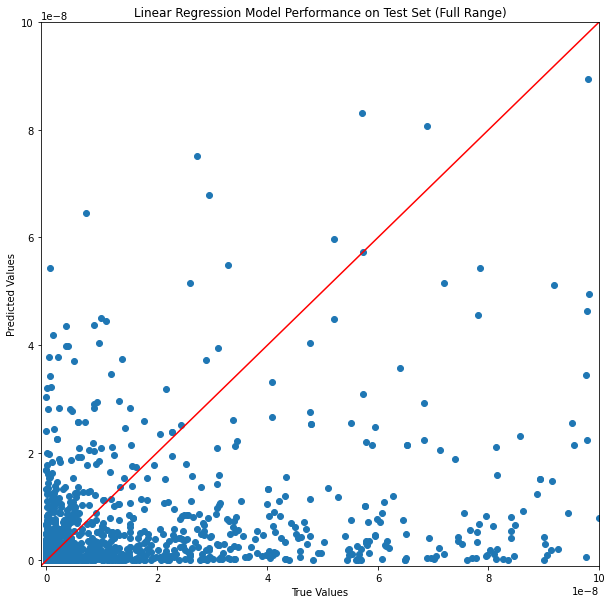

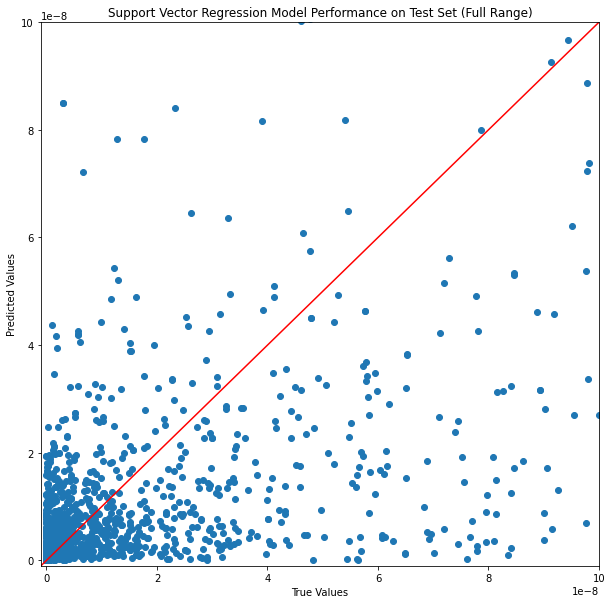

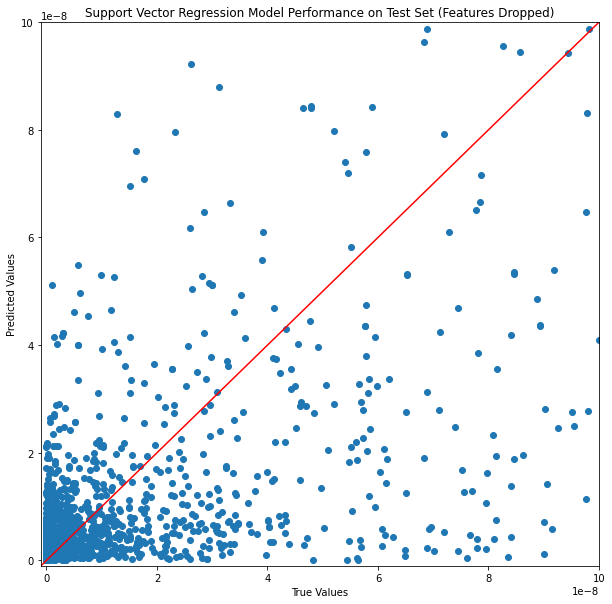

In [48]:
low = -1e-9
high = 1e-7
plt.figure(figsize=(10,10))
plt.scatter(y_test, y_pred_linreg)
plt.plot(np.linspace(low, high),np.linspace(low,high), c='r')
plt.title('Linear Regression Model Performance on Test Set (Full Range)')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.xlim([low, high])
plt.ylim([low, high])
plt.show()

plt.figure(figsize=(10,10))
plt.scatter(y_test, y_pred_svr)
plt.plot(np.linspace(low, high),np.linspace(low,high), c='r')
plt.title('Support Vector Regression Model Performance on Test Set (Full Range)')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.xlim([low, high])
plt.ylim([low, high])
plt.show()

plt.figure(figsize=(10,10))
plt.scatter(y_test, y_pred_svr_dropped)
plt.plot(np.linspace(low, high),np.linspace(low,high), c='r')
plt.title('Support Vector Regression Model Performance on Test Set (Features Dropped)')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.xlim([low, high])
plt.ylim([low, high])
plt.show()

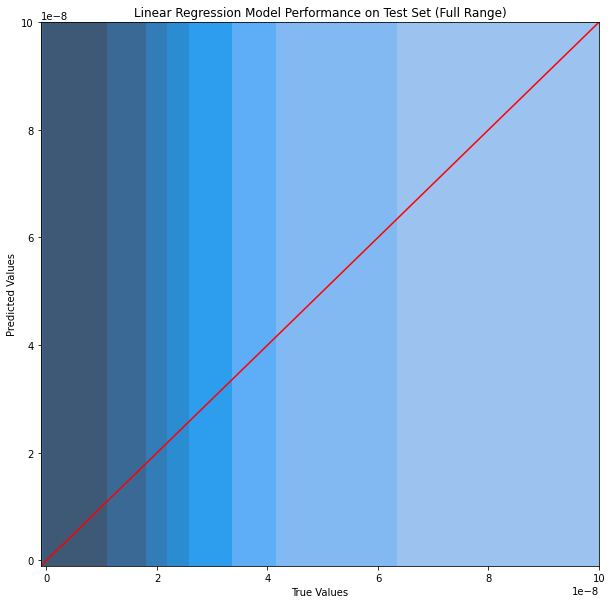

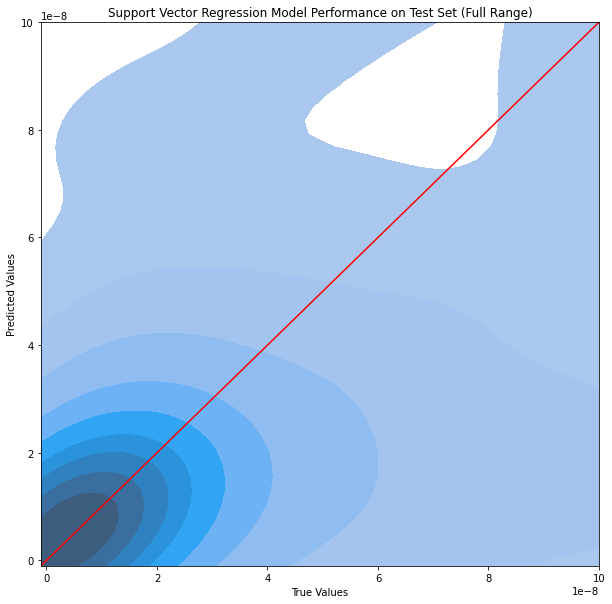

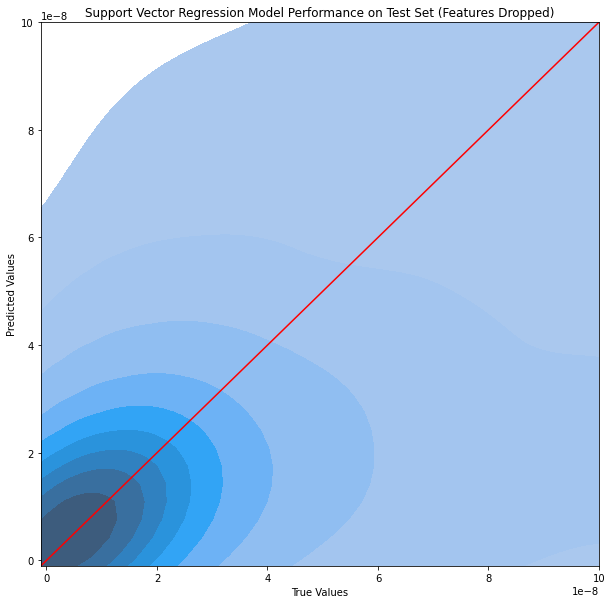

In [49]:
low = -1e-9
high = 1e-7
plt.figure(figsize=(10,10))
sns.kdeplot(x=y_test, y=y_pred_linreg, shade=True)
plt.plot(np.linspace(low, high),np.linspace(low,high), c='r')
plt.title('Linear Regression Model Performance on Test Set (Full Range)')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.xlim([low, high])
plt.ylim([low, high])
plt.show()

plt.figure(figsize=(10,10))
sns.kdeplot(x=y_test, y=y_pred_svr, shade=True)
plt.plot(np.linspace(low, high),np.linspace(low,high), c='r')
plt.title('Support Vector Regression Model Performance on Test Set (Full Range)')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.xlim([low, high])
plt.ylim([low, high])
plt.show()

plt.figure(figsize=(10,10))
sns.kdeplot(x=y_test, y=y_pred_svr_dropped, shade=True)
plt.plot(np.linspace(low, high),np.linspace(low,high), c='r')
plt.title('Support Vector Regression Model Performance on Test Set (Features Dropped)')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.xlim([low, high])
plt.ylim([low, high])
plt.show()

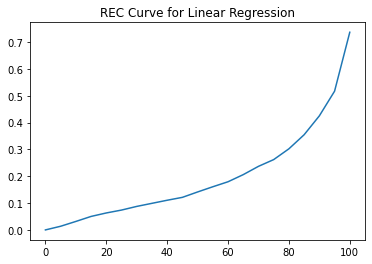

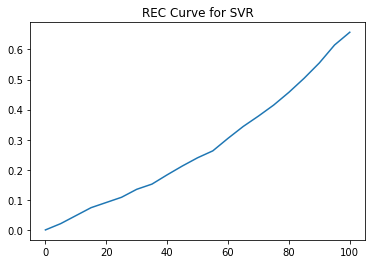

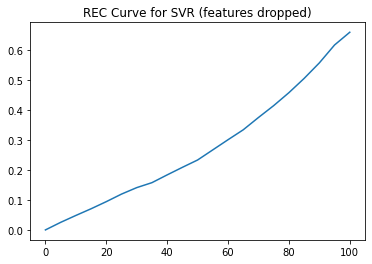

In [15]:
def REC(y_pred, y_test):
    percent_error = np.abs((y_pred-y_test)/y_test)*100
    thresholds = np.linspace(0,100, 21) #5% increments
    acc = np.zeros(thresholds.shape)
    for ii in range(len(thresholds)):
        n_correct = len(percent_error[percent_error<=thresholds[ii]])
        acc[ii] = n_correct/len(y_test)
    return thresholds, acc

# plot REC curve
thresholds_linreg, accuracy_linreg = REC(y_pred_linreg, y_test)
plt.plot(thresholds_linreg, accuracy_linreg )
plt.title('REC Curve for Linear Regression')
plt.show()

thresholds_svr, accuracy_svr = REC(y_pred_svr, y_test)
plt.plot(thresholds_svr, accuracy_svr)
plt.title('REC Curve for SVR')
plt.show()

thresholds_svr_dropped, accuracy_svr_dropped = REC(y_pred_svr_dropped, y_test)
plt.plot(thresholds_svr_dropped, accuracy_svr_dropped)
plt.title('REC Curve for SVR (features dropped)')
plt.show()